In [1]:
%load_ext lab_black

In [1]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import polars as pl
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger

import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from include.generators import InvDataGen
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver

import matplotlib_functions as mympf

setMatplotlibParam()
plt.viridis()

2024-02-06 15:33:53.753962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 15:33:53.753997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 15:33:53.754034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 15:33:53.760725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [3]:
dir_res = "/libre/dumontj/coco2/weights/new"
dir_ds = "/libre/dumontj/coco2/dl-input"

## Model

In [4]:
name_model = "inv_lip_test_32_sweep/4"

name_valid_nc = "2km_Dolo_32/dataset.nc"
name_valid_2_nc = "2km_Dolo_32_beta_distribution_mapping/dataset.nc"
name_extra_valid_nc = "2km_Lip_32/dataset.nc"


path_valid_1_nc = os.path.join(dir_ds, name_valid_nc)
path_valid_2_nc = os.path.join(dir_ds, name_valid_2_nc)
path_extra_valid_nc = os.path.join(dir_ds, name_extra_valid_nc)

In [5]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2024-01-19 11:15:27.634996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43495 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


## Valid 1 data

In [20]:
data_v1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_1_nc
)

ic| self.eval.shape: (4296, 32, 32, 3)


In [21]:
eval_v1 = model_eval.InversionModelEvaluation(model=model, data=data_v1)
metrics = eval_v1.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 2.7361734
mape: 35.166405


135/135 [==============================] - 1s 4ms/step


<Figure size 1920x1440 with 0 Axes>

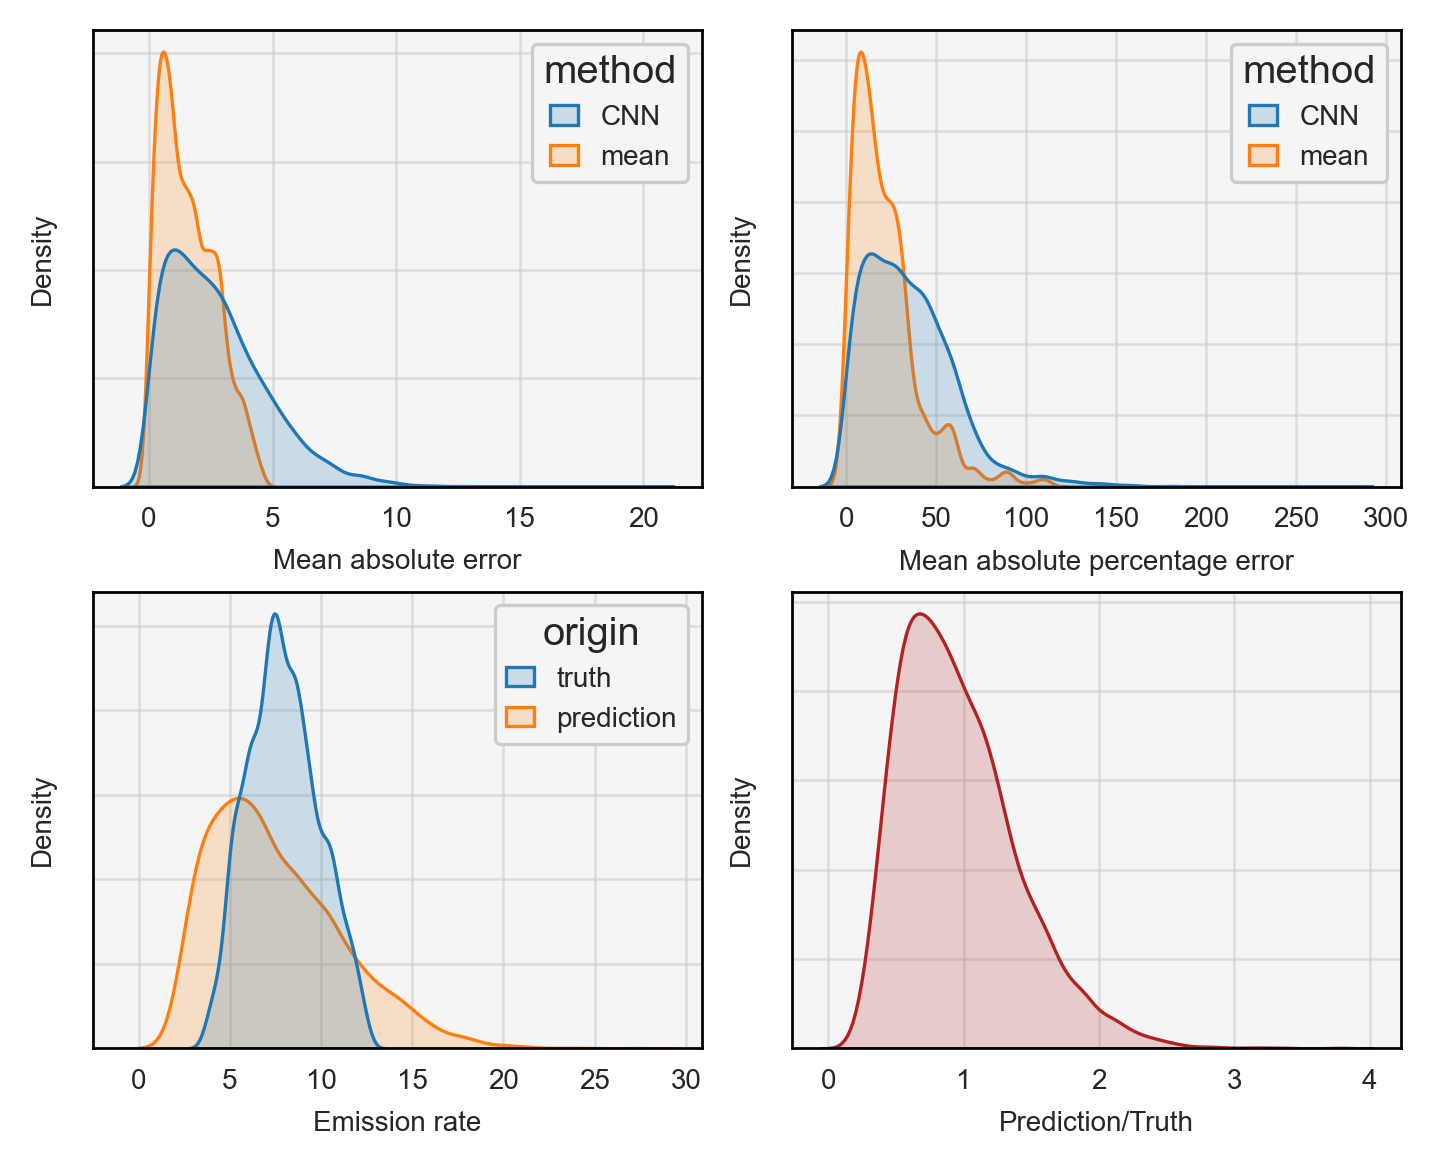

In [22]:
model_eval.get_summary_histo_inversion(model, data_v1)

## Valid 2 data

In [98]:
data_v2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_2_nc
)

ic| self.eval.shape: (4296, 32, 32, 3)


In [ ]:
eval_v2 = model_eval.InversionModelEvaluation(model=model, data=data_v2)
metrics = eval_v2.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 0s 1ms/step
mae: 4.828194
mape: 70.08047


In [9]:
from model_eval import *

<AxesSubplot: ylabel='Density'>

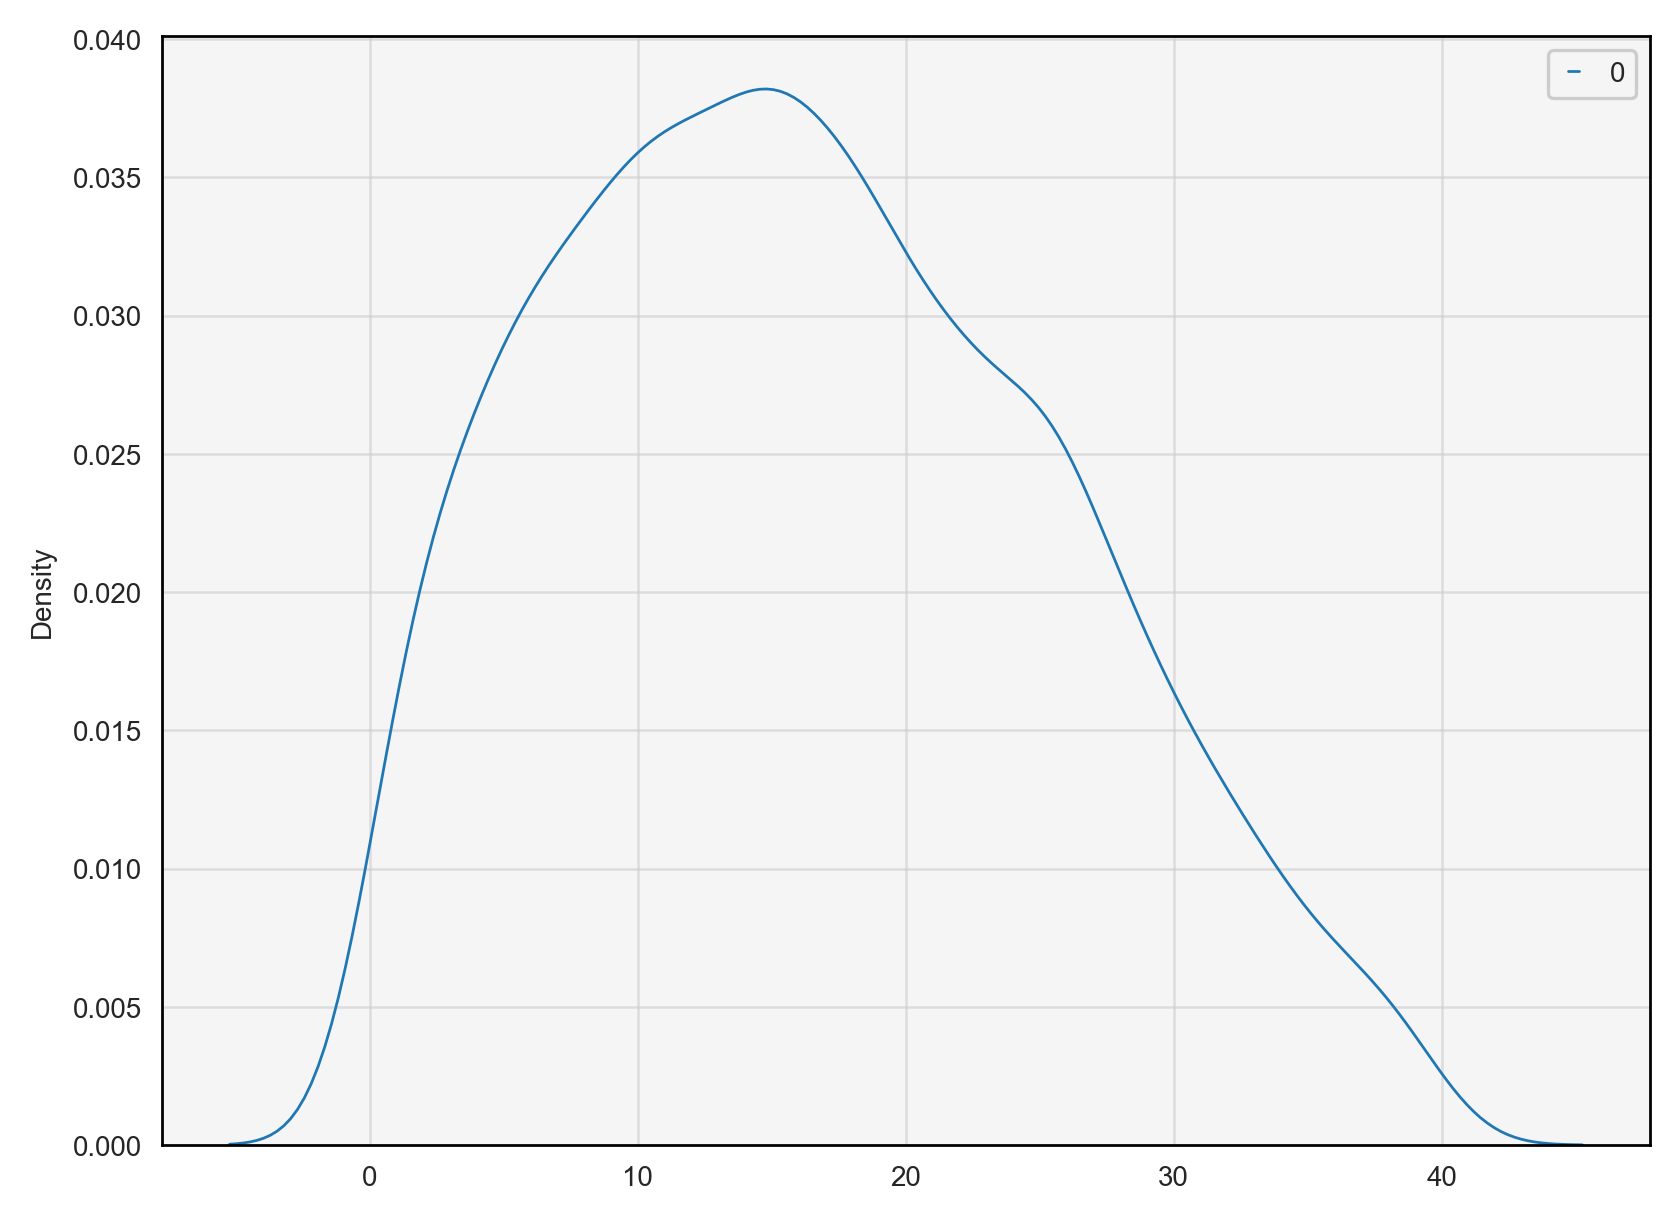

In [30]:
sns.kdeplot(data_v2.y.eval)

<AxesSubplot: ylabel='Count'>

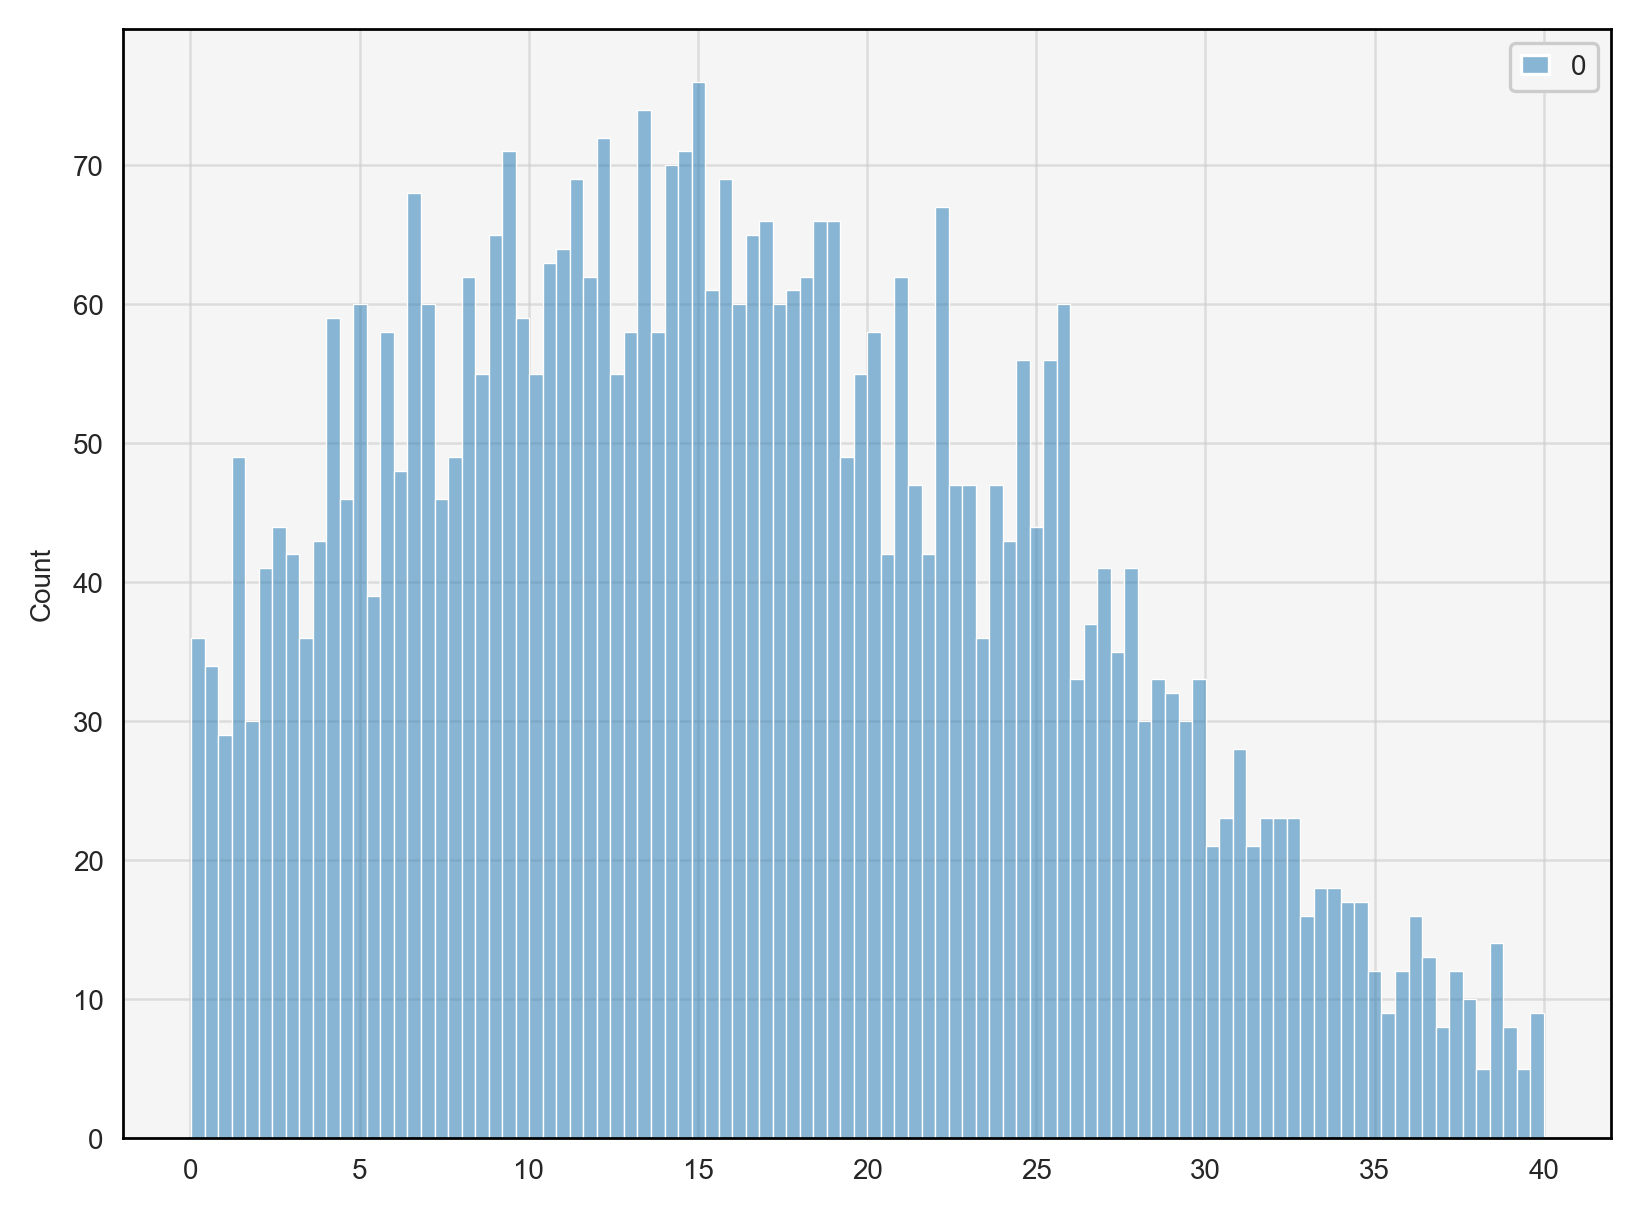

In [29]:
sns.histplot(data_v2.y.eval, bins=100)

In [31]:
def get_summary_histo_inversion(
    model: tf.keras.Model, data: Data_eval, dir_save: str = "None"
) -> None:
    """Get various histograms summing up the inversion results."""
    inv_eval = InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()

    y = tf.convert_to_tensor(data.y.eval, np.float32)
    mean_eval = InversionModelEvaluation(
        pred=tf.math.reduce_mean(y) * tf.ones_like(y, np.float32), y=y
    )
    mean_metrics = mean_eval.get_metrics()

    df_mae_1 = pd.DataFrame({"loss": metrics["mae"], "method": "CNN"})
    df_mae_2 = pd.DataFrame({"loss": mean_metrics["mae"], "method": "mean"})
    df_mae = pd.concat([df_mae_1, df_mae_2])

    df_mape_1 = pd.DataFrame({"loss": metrics["mape"], "method": "CNN"})
    df_mape_2 = pd.DataFrame({"loss": mean_metrics["mape"], "method": "mean"})
    df_mape = pd.concat([df_mape_1, df_mape_2])

    pred = np.squeeze(model.predict(tf.convert_to_tensor(data.x.eval, np.float32)))
    y = data.y.eval[:, -1]
    df_emiss_1 = pd.DataFrame({"emiss": y, "origin": "truth"})
    df_emiss_2 = pd.DataFrame({"emiss": pred, "origin": "prediction"})
    df_emiss = pd.concat([df_emiss_1, df_emiss_2])

    N_rows = 2
    N_cols = 2
    mympf.setMatplotlibParam()
    plt.viridis()
    axs = mympf.set_figure_axs(
        N_rows,
        N_cols,
        wratio=0.35,
        hratio=0.75,
        pad_w_ext_left=0.25,
        pad_w_ext_right=0.25,
        pad_w_int=0.3,
        pad_h_ext=0.3,
        pad_h_int=0.35,
    )

    sns.kdeplot(
        data=df_mae,
        x="loss",
        common_norm=True,
        hue="method",
        fill=True,
        alpha=0.2,
        ax=axs[0],
    )
    sns.histplot(
        data=df_mape,
        x="loss",
        common_norm=True,
        hue="method",
        fill=True,
        alpha=0.2,
        ax=axs[1],
    )
    sns.kdeplot(
        data=df_emiss,
        x="emiss",
        common_norm=True,
        hue="origin",
        palette="Set3",
        fill=False,
        alpha=1,
        ax=axs[2],
    )
    sns.kdeplot(pred / y, color="firebrick", fill=True, alpha=0.2, ax=axs[3])

    titles = [
        "Mean absolute error",
        "Mean absolute percentage error",
        "Emission rate",
        "Prediction/Truth",
    ]

    for i_ax, ax in enumerate(axs):
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_xlabel(titles[i_ax])

    if dir_save != "None":
        plt.savefig(os.path.join(dir_save, "summary_inv.png"))

135/135 [==============================] - 1s 4ms/step


<Figure size 1920x1440 with 0 Axes>

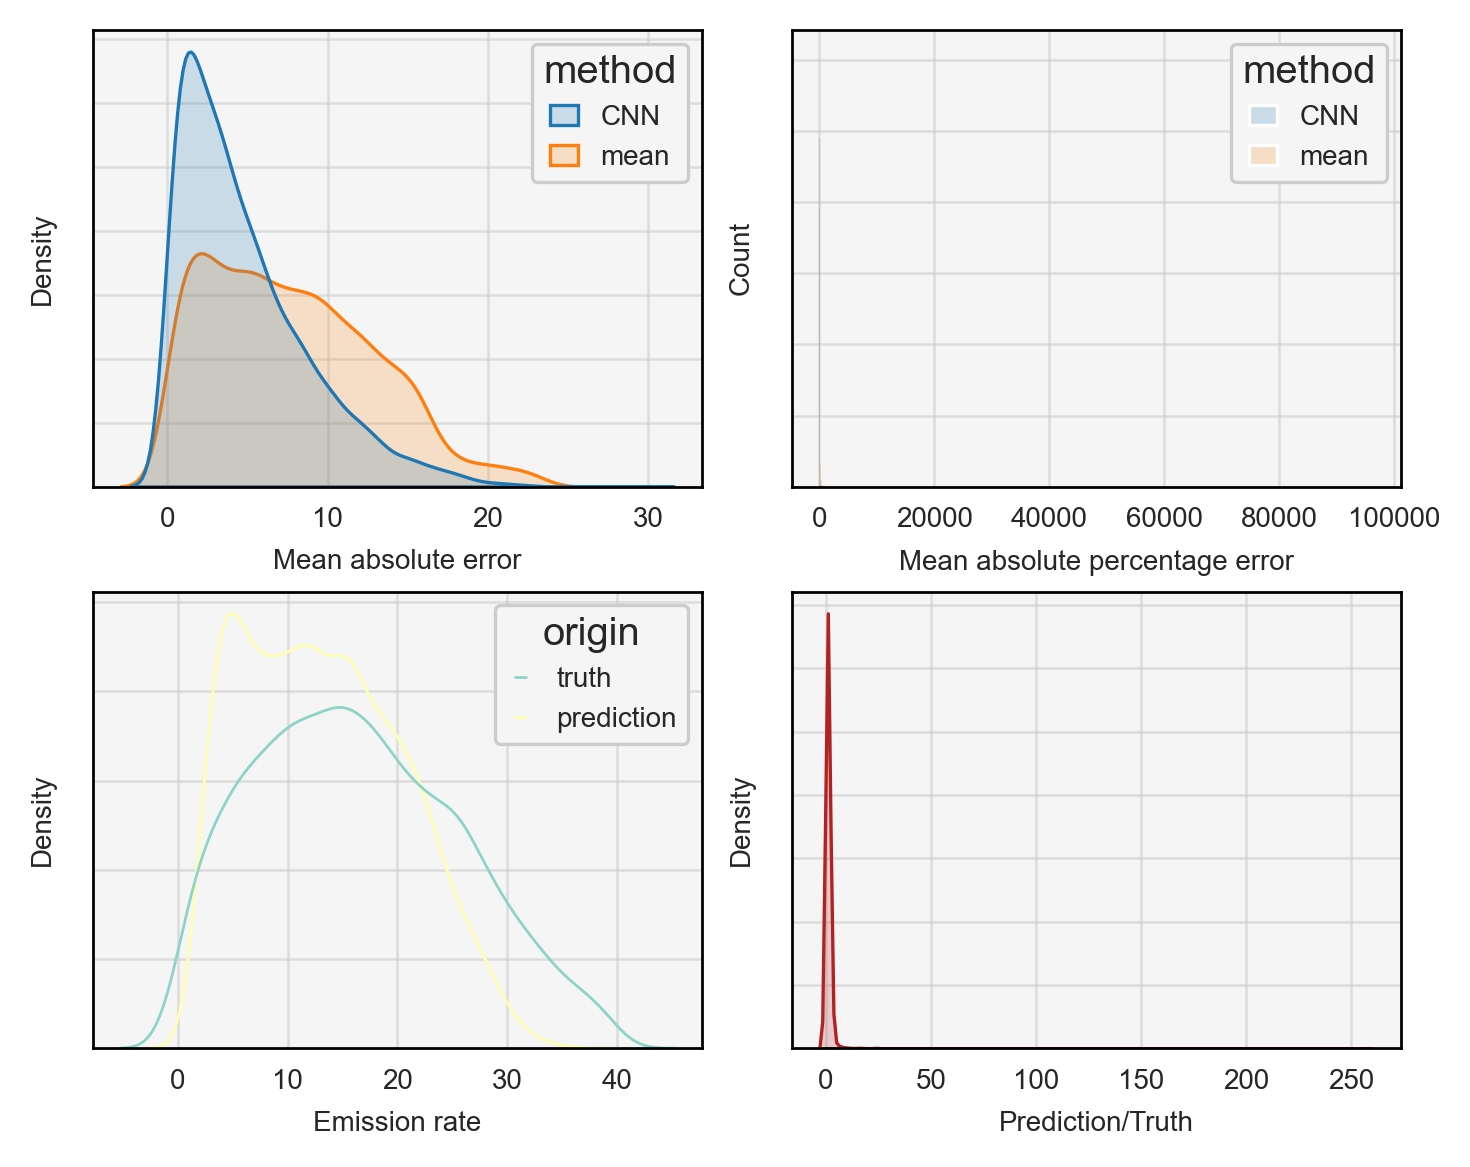

In [32]:
get_summary_histo_inversion(model, data_v2)

## Extra_valid data

In [6]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc
)

ic| self.eval.shape: (4296, 32, 32, 3)
2024-01-19 11:15:30.075536: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
num_examples = 5
plot_data = data.x.eval
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [8]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

2024-01-19 11:15:32.976656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-19 11:15:33.451759: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


135/135 [==============================] - 2s 4ms/step
mae: 3.9289792
mape: 26.808262


135/135 [==============================] - 0s 3ms/step


<Figure size 1920x1440 with 0 Axes>

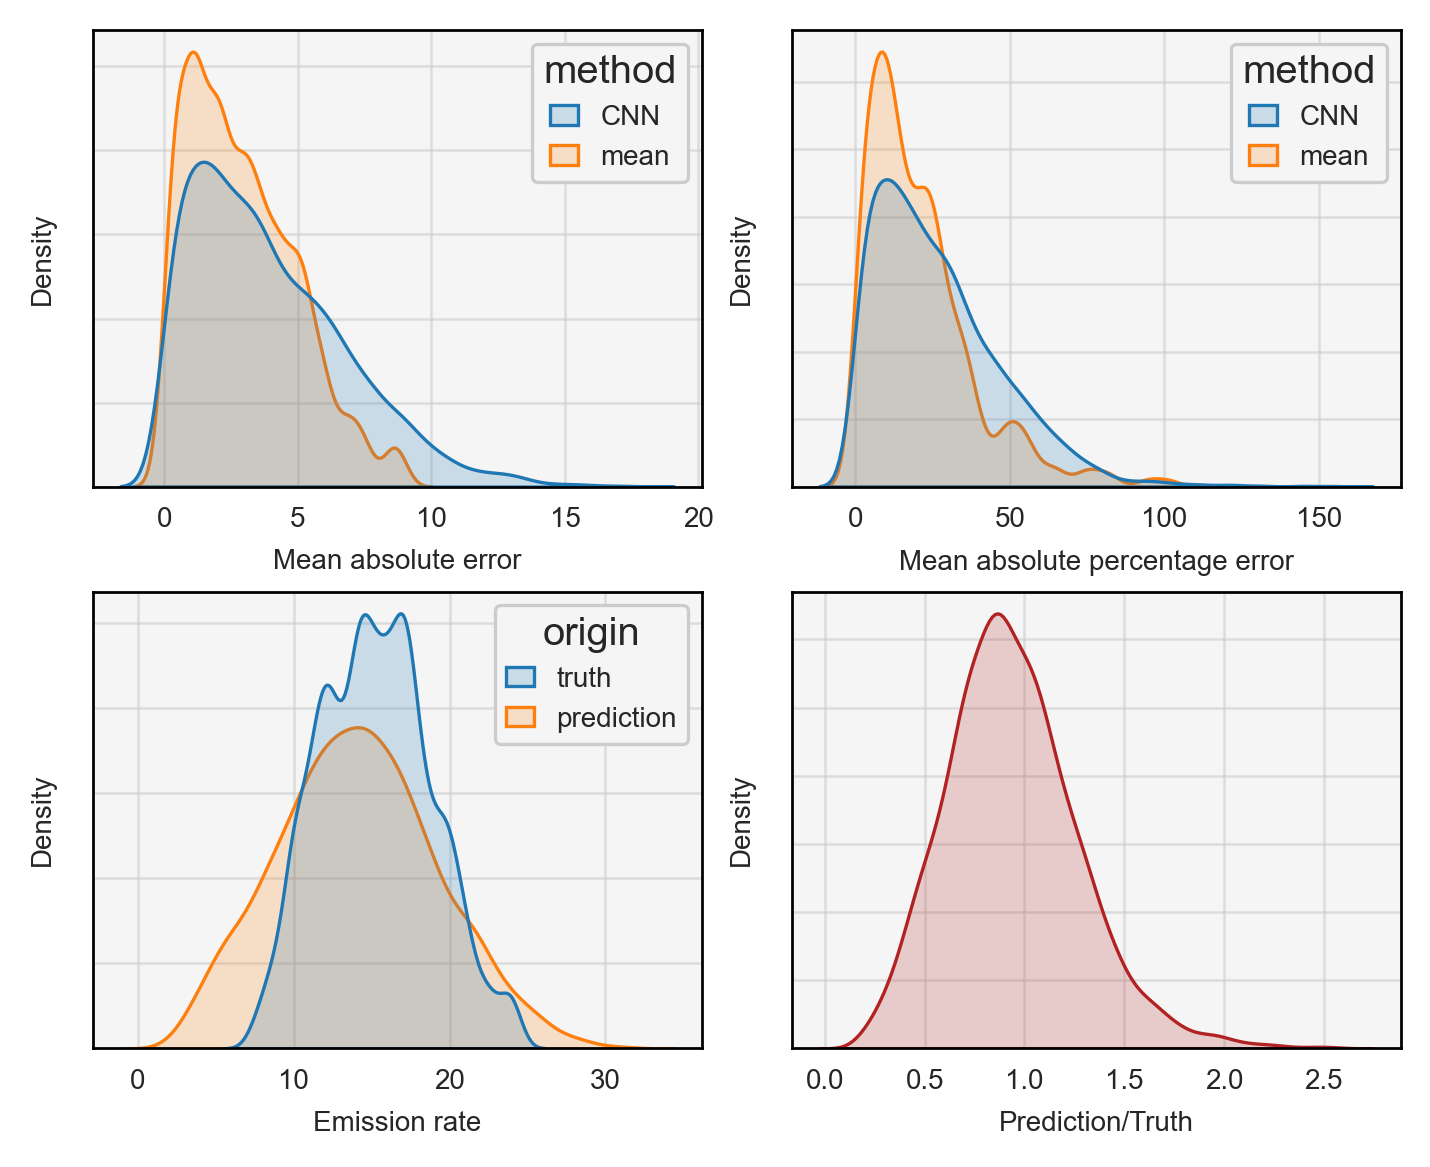

In [9]:
model_eval.get_summary_histo_inversion(model, data)

### Plot results (worst)

In [26]:
def count_and_get_images_in_quantile_range(metrics, lower_quantile, upper_quantile):
    lower_bound = np.quantile(metrics, lower_quantile)
    upper_bound = np.quantile(metrics, upper_quantile)
    filtered_metrics = metrics[(metrics >= lower_bound) & (metrics <= upper_bound)]
    count = len(filtered_metrics)
    return count, filtered_metrics


count, values = count_and_get_images_in_quantile_range(metrics["mae"], 0.95, 1)

In [30]:
inv_plotter = model_eval.InversionPlotter(inv_eval)
inv_plotter.N_rows = 10
inv_plotter.plot_examples(interval=[0.95, 1])

### Plot integrated gradients

In [31]:
def get_integ_grad(data: Data_eval, idx: int = None):
    if not idx:
        idx = np.random.choice(data.ds.attrs["N_img"])
    x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
    baseline_tensor = tf.zeros_like(x)
    integ_grad = model_eval.integrated_gradients(model, x, baseline_tensor).numpy()
    return idx, integ_grad

In [46]:
(idx0, integ_grad_0) = get_integ_grad(data)
(idx1, integ_grad_1) = get_integ_grad(data)
(idx2, integ_grad_2) = get_integ_grad(data)
(idx3, integ_grad_3) = get_integ_grad(data)

In [47]:
plume = np.array(data.x.ds_eval.plume)

In [48]:
list_idx = [idx0, idx1, idx2, idx3]
list_data = [data, data, data, data]
list_plume = [plume, plume, plume, plume]
list_integ_grad = [
    integ_grad_0,
    integ_grad_1,
    integ_grad_2,
    integ_grad_3,
]
list_sources = ["Lippendorf", "Lippendorf", "Lippendorf", "Lippendorf"]

<Figure size 1920x1440 with 0 Axes>

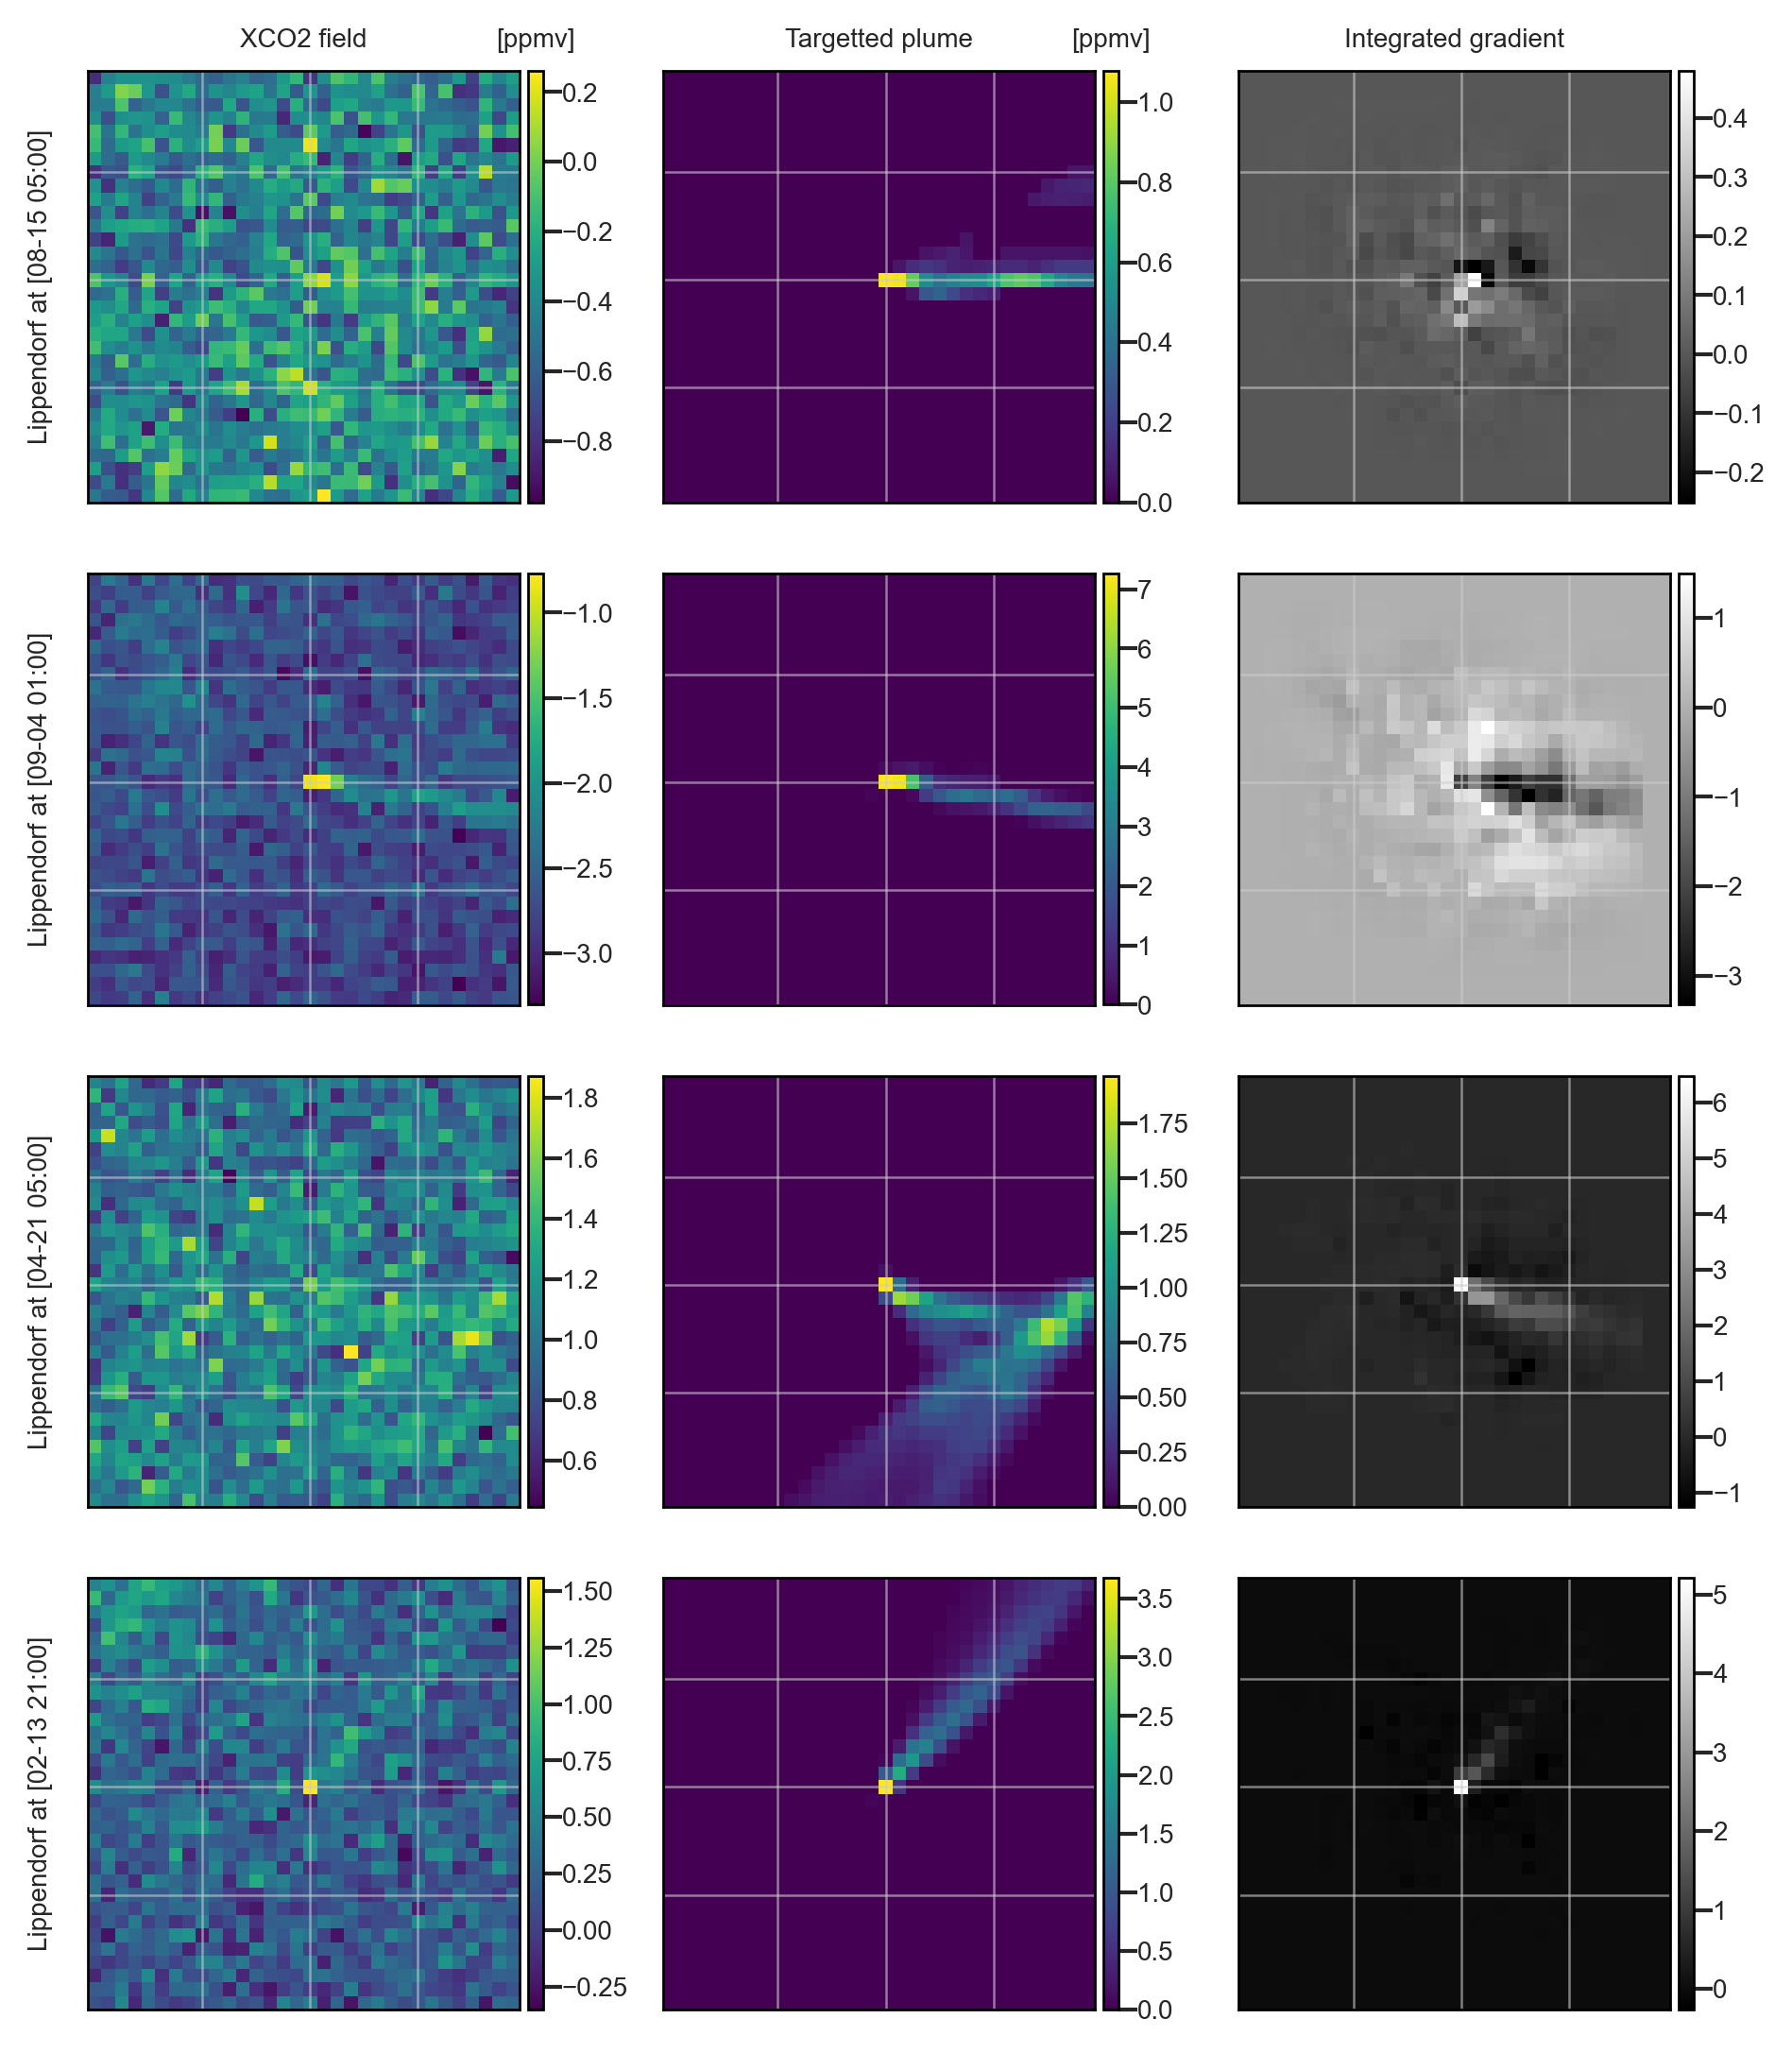

In [49]:
N_idx = 4
N_cols = 3
mympf.setMatplotlibParam(target="pres")
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i_row, (idx, data, plume, integ_grad) in enumerate(
    zip(list_idx, list_data, list_plume, list_integ_grad)
):
    for i_col, image in enumerate(
        [
            np.squeeze(data.x.eval[idx, :, :, 0]),
            np.squeeze(plume[idx, :, :]),
            np.squeeze(integ_grad[:, :, 0]),
        ]
    ):

        i_ax = i_col + i_row * N_cols
        ims[i_ax] = axs[i_ax].imshow(
            image, cmap="gray" if i_col == 2 else None, origin="lower"
        )
        caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))

        cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

list_pd_t = []
for (idx, data) in zip(list_idx, list_data):
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, (pd_t_idx, source) in enumerate(zip(list_pd_t, list_sources)):
    axs[i * N_cols].set_ylabel(
        f"{source} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Integrated gradient")

cbars[0].ax.set_title("[ppmv]")
cbars[1].ax.set_title("[ppmv]")

plt.show()

### Uncertainty quantification

#### Dropout

In [294]:
from keras.layers import Lambda
import keras.backend as K
from keras.models import Model
from keras.layers import Dropout, Input

In [295]:
def custom_dropout(x, level=0.2):
    return K.dropout(x, level=level)

##### Dropout à 0.2

In [303]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.2)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [304]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 41/135 [========>.....................] - ETA: 0s

2024-01-15 18:23:20.945815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_51/tf.nn.dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [305]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [306]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9105513
mape: 26.7817


In [307]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [308]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.09244977],
       [-0.09244977,  1.        ]])

##### Dropout à 0.3

In [333]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.3)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [334]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 40/135 [=======>......................] - ETA: 0s

2024-01-15 18:27:37.855943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_54/tf.nn.dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [335]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [336]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.8951368
mape: 26.723661


In [337]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 0s 3ms/step
mae: 3.9291296
mape: 26.809132


In [338]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.09719808],
       [-0.09719808,  1.        ]])

##### Dropout à 0.4

In [327]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.4)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [328]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

135/135 [==============================] - 1s 4ms/step


In [329]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [330]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.8975937
mape: 26.829601


In [331]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [332]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.       , -0.1167675],
       [-0.1167675,  1.       ]])

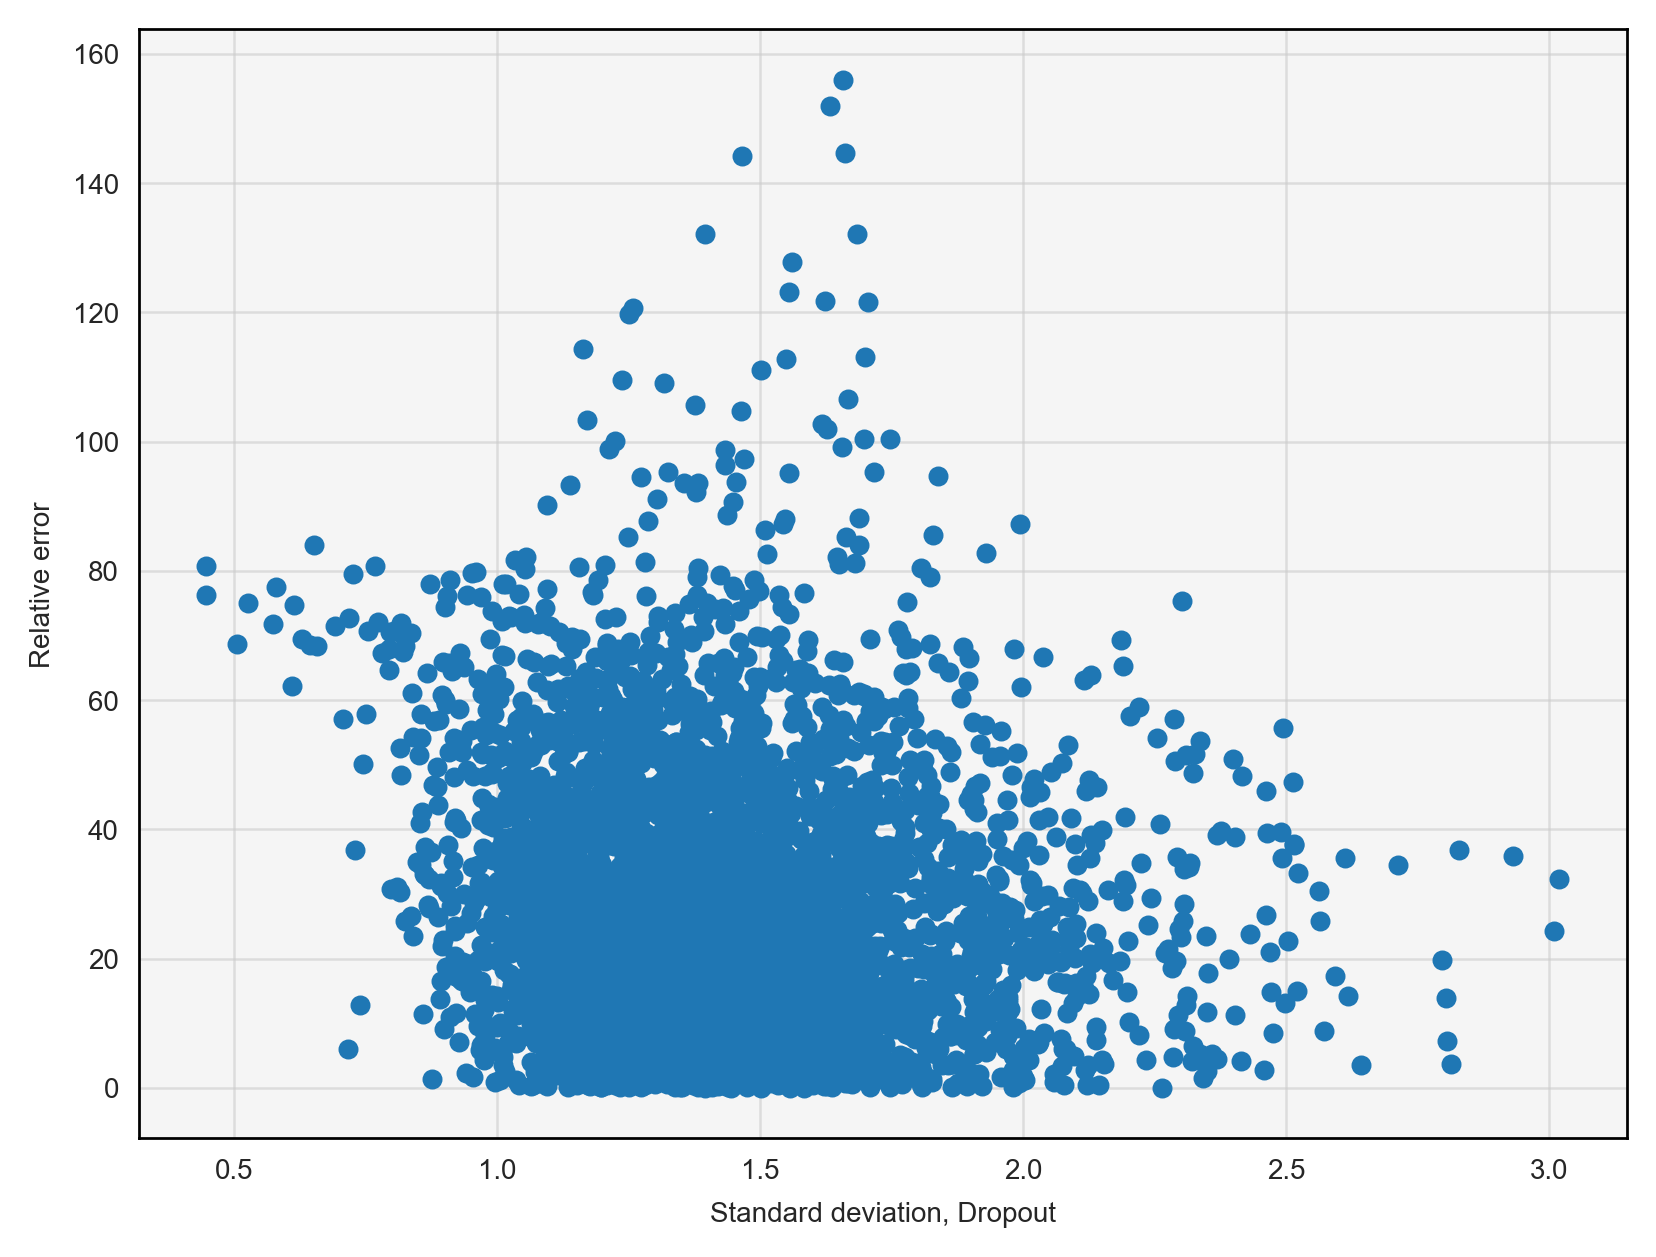

In [340]:
plt.scatter(np.squeeze(stds), metrics["mape"].numpy())
plt.xlabel("Standard deviation, Dropout")
plt.ylabel("Relative error")
plt.show()

##### Dropout à 0.5

In [321]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.5)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [322]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 49/135 [=========>....................] - ETA: 0s

2024-01-15 18:26:25.716619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_52/tf.nn.dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [323]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [324]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9905834
mape: 27.627441


In [325]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [326]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[1.        , 0.01785866],
       [0.01785866, 1.        ]])

##### Dropout à 0.0

In [266]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.0)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [273]:
model.predict(data.x.eval)

135/135 [==============================] - 0s 3ms/step


array([[ 3.6927001],
       [12.490109 ],
       [ 7.881086 ],
       ...,
       [ 6.510739 ],
       [ 9.679227 ],
       [15.386527 ]], dtype=float32)

In [274]:
new_model.predict(data.x.eval)

135/135 [==============================] - 1s 4ms/step


array([[ 3.6927001],
       [12.490109 ],
       [ 7.881086 ],
       ...,
       [ 6.510739 ],
       [ 9.679227 ],
       [15.386527 ]], dtype=float32)

In [267]:
predictions = []

for _ in range(10):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

135/135 [==============================] - 1s 4ms/step


In [280]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [283]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9291296
mape: 26.809132


In [284]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [286]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.08889776],
       [-0.08889776,  1.        ]])

#### Ensembling

In [344]:
dir_sweep = os.path.join(dir_res, "inv_lip_test_32_sweep")

In [345]:
list_names_model = ["4", "5", "6", "7"]

In [348]:
list_paths_model = [
    os.path.join(dir_sweep, name_model) for name_model in list_names_model
]
list_paths_model

['/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/4',
 '/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/5',
 '/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/6',
 '/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/7']

In [350]:
name_extra_valid_nc = "2km_Lip_32/dataset.nc"
path_extra_valid_nc = os.path.join(dir_ds, name_extra_valid_nc)

In [372]:
from model_eval import (
    get_data_for_inversion,
    InversionModelEvaluation,
    print_inv_metrics,
)

In [366]:
path_ds_nc = path_extra_valid_nc
data_similar = False

In [373]:
data = get_data_for_inversion(list_paths_model[0], path_ds_nc)
pred = tf.zeros_like(data.y.eval, np.float32)
for path_model in list_paths_model:
    if not data_similar:
        data = get_data_for_inversion(path_model, path_ds_nc)
    model_eval = InversionModelEvaluation(data=data, dir_res=path_model)
    pred += tf.convert_to_tensor(model_eval.pred, np.float32)

    print_inv_metrics(model_eval.get_metrics(), message=path_model)
pred = pred / len(list_paths_model)
ensemble_model_eval = InversionModelEvaluation(data=data, pred=pred)
metrics = ensemble_model_eval.get_metrics()
print_inv_metrics(metrics, message="\nEnsemble")

ic| self.eval.shape: (4296, 32, 32, 3)
ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/4
MAE 3.8103805 3.2514427
MAPE 25.828455 21.735388


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/5
MAE 3.8344004 3.271966
MAPE 25.776129 22.17398


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 0s 3ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/6
MAE 3.838899 3.2899017
MAPE 26.084942 22.021507


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 0s 3ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/7
MAE 3.6728024 3.089128
MAPE 24.74554 20.67641

Ensemble
MAE 3.6636415 3.122674
MAPE 24.73811 21.100792


In [375]:
predictions = []

for path_model in list_paths_model:
    if not data_similar:
        data = get_data_for_inversion(path_model, path_ds_nc)
    model_eval = InversionModelEvaluation(data=data, dir_res=path_model)
    current_pred = tf.convert_to_tensor(model_eval.pred, np.float32)
    predictions.append(current_pred)

    print_inv_metrics(model_eval.get_metrics(), message=path_model)

# Convert list of predictions to a tensor or numpy array
predictions_array = tf.stack(predictions).numpy()

ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/4
MAE 3.8103805 3.2514427
MAPE 25.828455 21.735388


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/5
MAE 3.8344004 3.271966
MAPE 25.776129 22.17398


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/6
MAE 3.838899 3.2899017
MAPE 26.084942 22.021507


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/7
MAE 3.6728024 3.089128
MAPE 24.74554 20.67641


In [377]:
predictions_array = predictions_array.numpy()

In [380]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [382]:
inv_eval = InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.6636415
mape: 24.73811


In [384]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.02669349],
       [-0.02669349,  1.        ]])

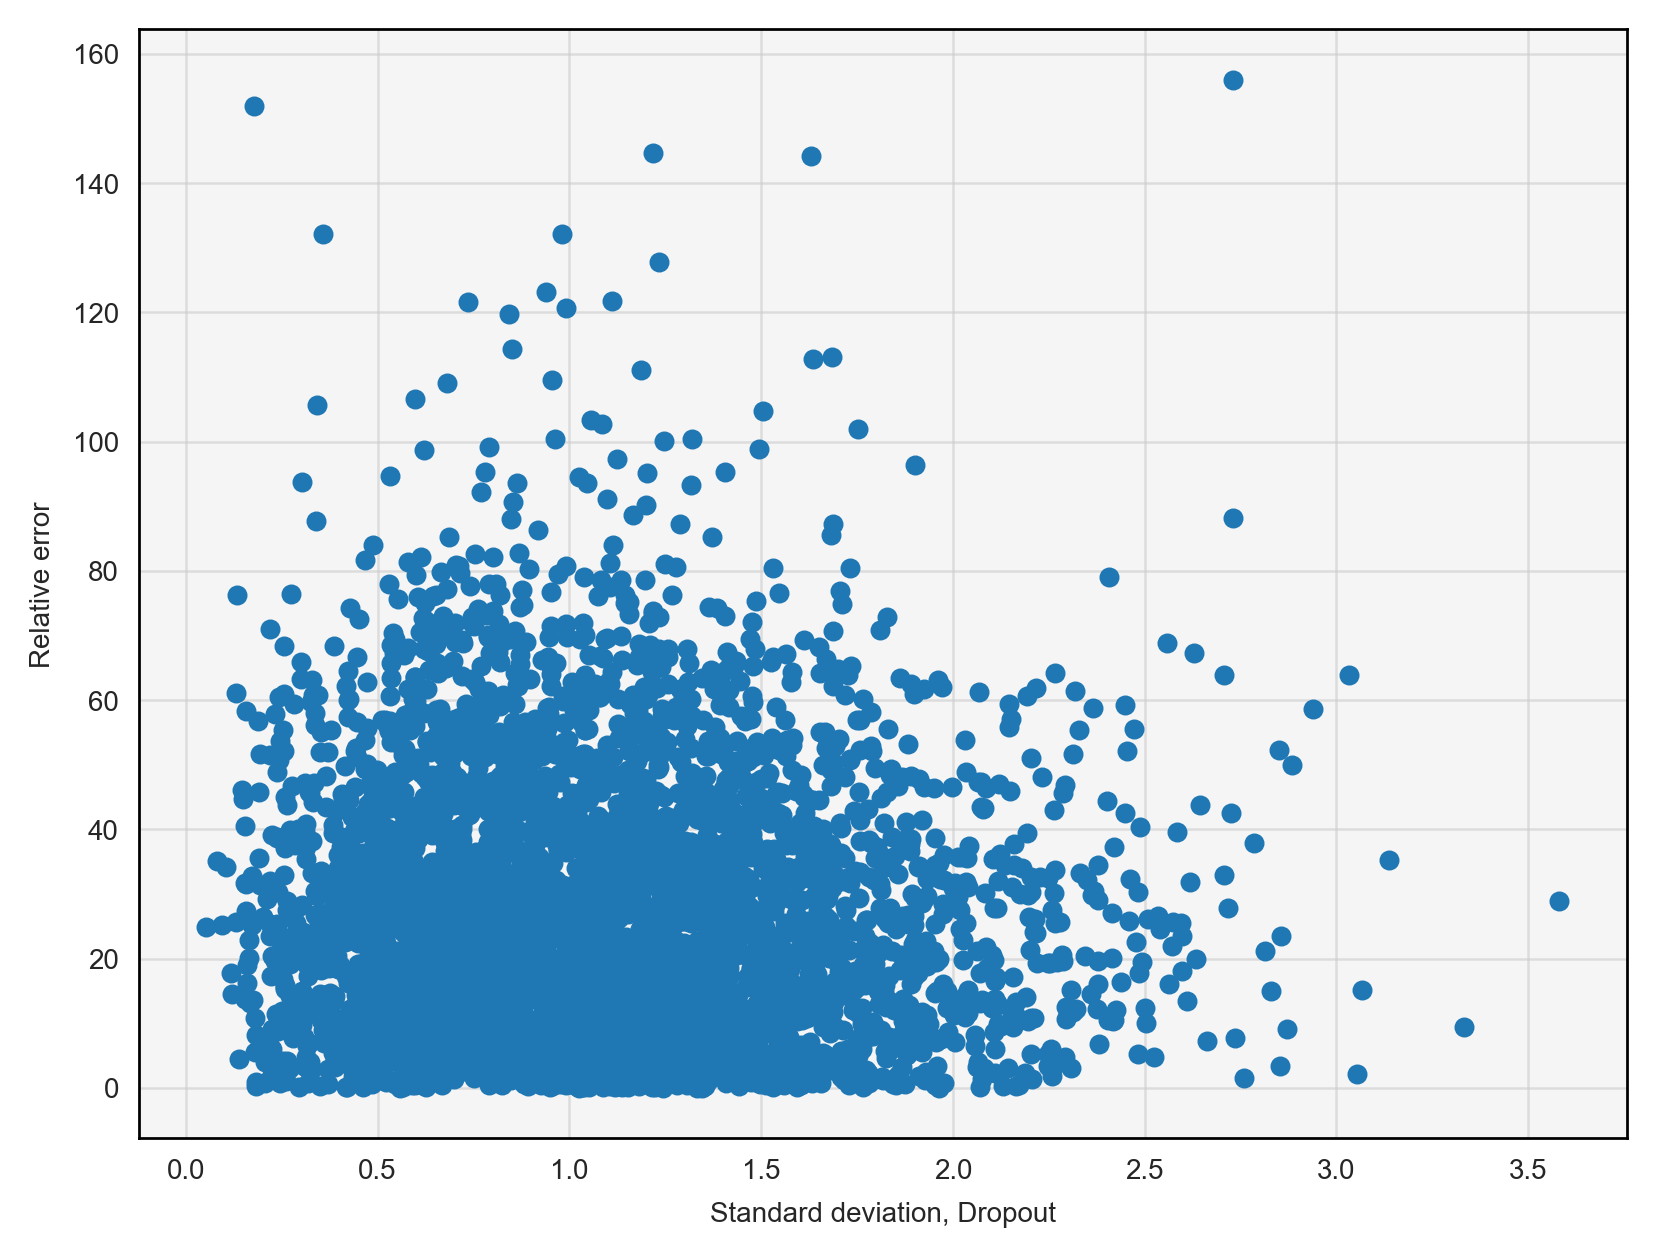

In [386]:
plt.scatter(np.squeeze(stds), metrics["mape"].numpy())
plt.xlabel("Standard deviation, Dropout")
plt.ylabel("Relative error")
plt.show()

### With Gaussian layer

In [90]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 0s 2ms/step
mae: 3.9289792
mape: 26.808262


In [91]:
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

In [92]:
noisy_predictions = []

for _ in range(10):
    noise = np.random.normal(0, 0.1, data.x.eval.shape)
    noisy_data = data.x.eval + noise

    # Predict using your model (assuming it's named 'reg_inv_model')
    predictions = model.predict(noisy_data)

    # Store predictions
    noisy_predictions.append(predictions)
noisy_predictions = np.array(noisy_predictions)

noisy_mae = []
for prediction in noisy_predictions:
    noisy_mae.append(mae(data.y.eval, prediction))
noisy_mae = np.array(noisy_mae)

means = np.mean(noisy_mae, axis=0)
stds = np.std(noisy_mae, axis=0)

135/135 [==============================] - 0s 1ms/step


In [93]:
np.corrcoef(np.squeeze(stds), metrics["mae"].numpy())[0, 1]

0.22128169791790142

In [94]:
noisy_predictions = []

for _ in range(10):
    noise = np.random.normal(0, 0.1, data.x.eval.shape)
    noisy_data = data.x.eval + noise

    # Predict using your model (assuming it's named 'reg_inv_model')
    predictions = model.predict(noisy_data)

    # Store predictions
    noisy_predictions.append(predictions)
noisy_predictions = np.array(noisy_predictions)

noisy_mae = []
for prediction in noisy_predictions:
    noisy_mae.append(mae(data.y.eval, prediction))
noisy_mae = np.array(noisy_mae)

means = np.mean(noisy_mae, axis=0)
stds = np.std(noisy_mae, axis=0)

135/135 [==============================] - 0s 1ms/step


In [95]:
np.corrcoef(np.squeeze(stds), metrics["mae"].numpy())[0, 1]

0.23078346990608462

In [122]:
def compute_noisy_predictions(
    model: tf.keras.models.Model, n_pred: int, noise_level: int
):
    noisy_predictions = []
    for _ in range(n_pred):
        noise = np.random.normal(0, noise_level, data.x.eval.shape)
        noisy_data = data.x.eval + noise
        predictions = model.predict(noisy_data)
        noisy_predictions.append(predictions)
    noisy_predictions = np.array(noisy_predictions)
    return noisy_predictions


def compute_noisy_stds(noisy_predictions: np.ndarray, data):
    noisy_mae = []
    for prediction in noisy_predictions:
        noisy_mae.append(mae(data.y.eval, prediction))
    noisy_mae = np.array(noisy_mae)
    stds = np.std(noisy_mae, axis=0)
    return stds

In [130]:
def compute_corrcoef_noisystd_error(model, data, n_pred=10, noise_level=0.1):
    inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()
    noisy_predictions = compute_noisy_predictions(model, n_pred, noise_level)
    stds = compute_noisy_stds(noisy_predictions, data)

    return np.corrcoef(np.squeeze(stds), metrics["mae"].numpy())[0, 1]

In [131]:
corrcoeff = compute_corrcoef_noisystd_error(model, data, 10, 0.1)
corrcoeff

135/135 [==============================] - 0s 1ms/step


0.23901153003709427

In [143]:
def compute_corr_for_range_noises(
    model, data, n_pred, noise_levels=[0.05, 0.1, 0.2, 0.3, 0.4]
):
    inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()
    all_corrcoefs = []
    all_stds = []
    for noise_level in noise_levels:
        ic(noise_level)
        noisy_predictions = compute_noisy_predictions(model, n_pred, noise_level)
        stds = compute_noisy_stds(noisy_predictions, data)
        all_corrcoefs.append(
            np.corrcoef(np.squeeze(stds), metrics["mae"].numpy())[0, 1]
        )
        all_stds.append(stds)
    return all_corrcoefs, all_stds

In [136]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(model, data_v2, 10)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.05


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.1


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.3


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.4


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.1164918574497931,
                    0.13793536064141756,
                    0.15094577439057413,
                    0.14928641023814146,
                    0.10225677545427359]


[0.1164918574497931,
 0.13793536064141756,
 0.15094577439057413,
 0.14928641023814146,
 0.10225677545427359]

In [137]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(model, data_v2, 20)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.05


135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.1


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.3


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.4


135/135 [==============================] - 0s 2ms/step


ic| all_corrcoefs: [0.12747394217768512,
                    0.14727784713689546,
                    0.17171515220407585,
                    0.17264112608631813,
                    0.134998059587992]


[0.12747394217768512,
 0.14727784713689546,
 0.17171515220407585,
 0.17264112608631813,
 0.134998059587992]

In [135]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(model, data, 10)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.05


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.1


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.3


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.4


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.1744761461130439,
                    0.23990547806237372,
                    0.29830586263844094,
                    0.2655611240684969,
                    0.2119858919224115]


[0.1744761461130439,
 0.23990547806237372,
 0.29830586263844094,
 0.2655611240684969,
 0.2119858919224115]

In [139]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(model, data, 20)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.05


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.1


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.3


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.4


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.17400800596277666,
                    0.261515347330802,
                    0.31640871676948024,
                    0.31514995470243734,
                    0.24468673614798098]


[0.17400800596277666,
 0.261515347330802,
 0.31640871676948024,
 0.31514995470243734,
 0.24468673614798098]

In [140]:
all_stds = np.array(all_stds)
all_stds.shape

(5, 4296)

135/135 [==============================] - 0s 2ms/step


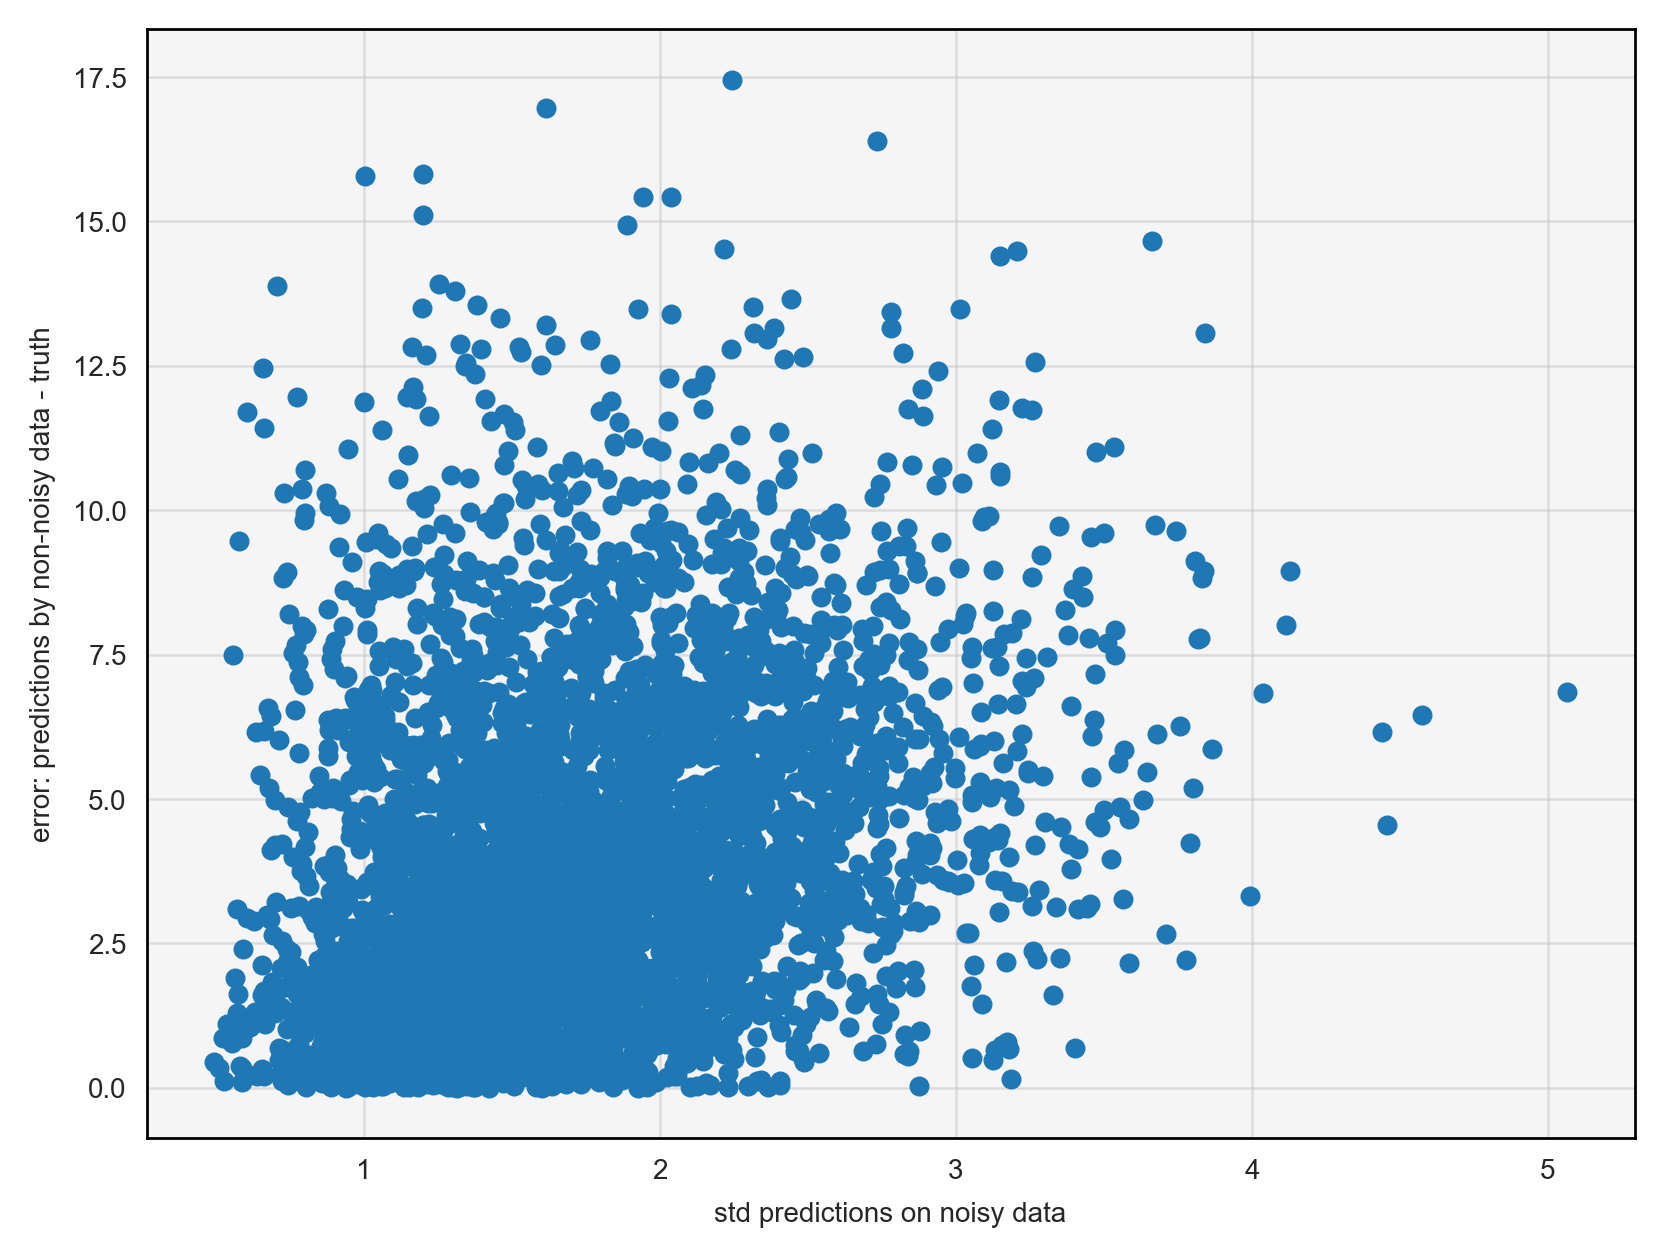

In [142]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
plt.scatter(np.squeeze(all_stds[2]), metrics["mae"].numpy())
plt.xlabel("std predictions on noisy data")
plt.ylabel("error: predictions by non-noisy data - truth")
plt.show()

In [144]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(
    model, data_v2, 30, noise_levels=[0.2, 0.25, 0.3]
)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.25


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.3


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.18302864322752382, 0.17811521862081095, 0.17594772028429403]


[0.18302864322752382, 0.17811521862081095, 0.17594772028429403]

In [147]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(
    model, data_v2, 100, noise_levels=[0.18, 0.2, 0.22, 0.24]
)
ic(all_corrcoefs)

135/135 [==============================] - 0s 2ms/step


ic| noise_level: 0.18


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.22


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.24


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.19555286881552644,
                    0.19302389168268663,
                    0.19825308264048883,
                    0.19523446214892032]


[0.19555286881552644,
 0.19302389168268663,
 0.19825308264048883,
 0.19523446214892032]

In [148]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(
    model, data, 100, noise_levels=[0.18, 0.2, 0.22, 0.24]
)
ic(all_corrcoefs)

135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.18


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.2


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.22


135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.24


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.3506336080228624,
                    0.35447194569169427,
                    0.3614187655678394,
                    0.3582782289239021]


[0.3506336080228624,
 0.35447194569169427,
 0.3614187655678394,
 0.3582782289239021]

135/135 [==============================] - 0s 1ms/step


ic| noise_level: 0.22


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.3562696786760211]


135/135 [==============================] - 0s 1ms/step


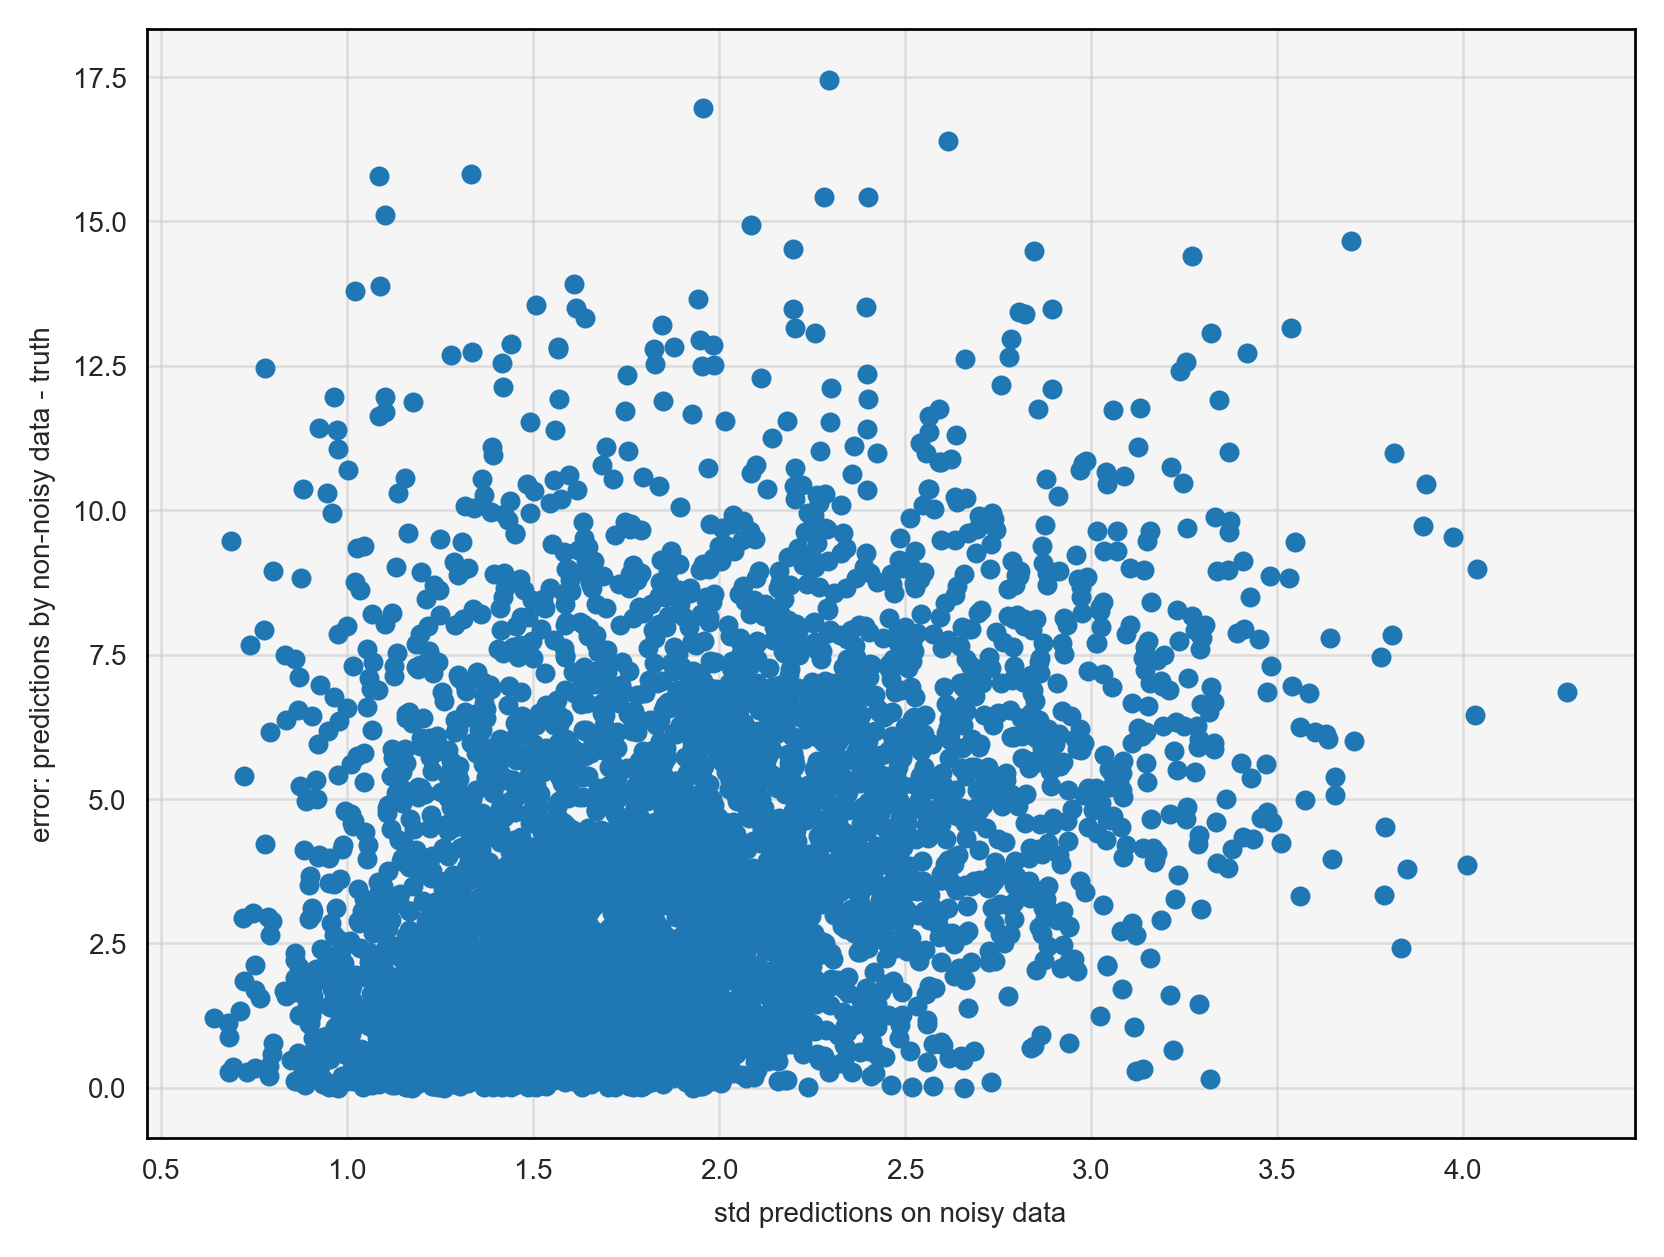

In [149]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(
    model, data, 100, noise_levels=[0.22]
)
ic(all_corrcoefs)

inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()

plt.scatter(np.squeeze(all_stds[0]), metrics["mae"].numpy())
plt.xlabel("std predictions on noisy data")
plt.ylabel("error: predictions by non-noisy data - truth")
plt.show()

135/135 [==============================] - 0s 3ms/step


ic| noise_level: 0.22


135/135 [==============================] - 0s 1ms/step


ic| all_corrcoefs: [0.3702123806540422]


135/135 [==============================] - 0s 2ms/step


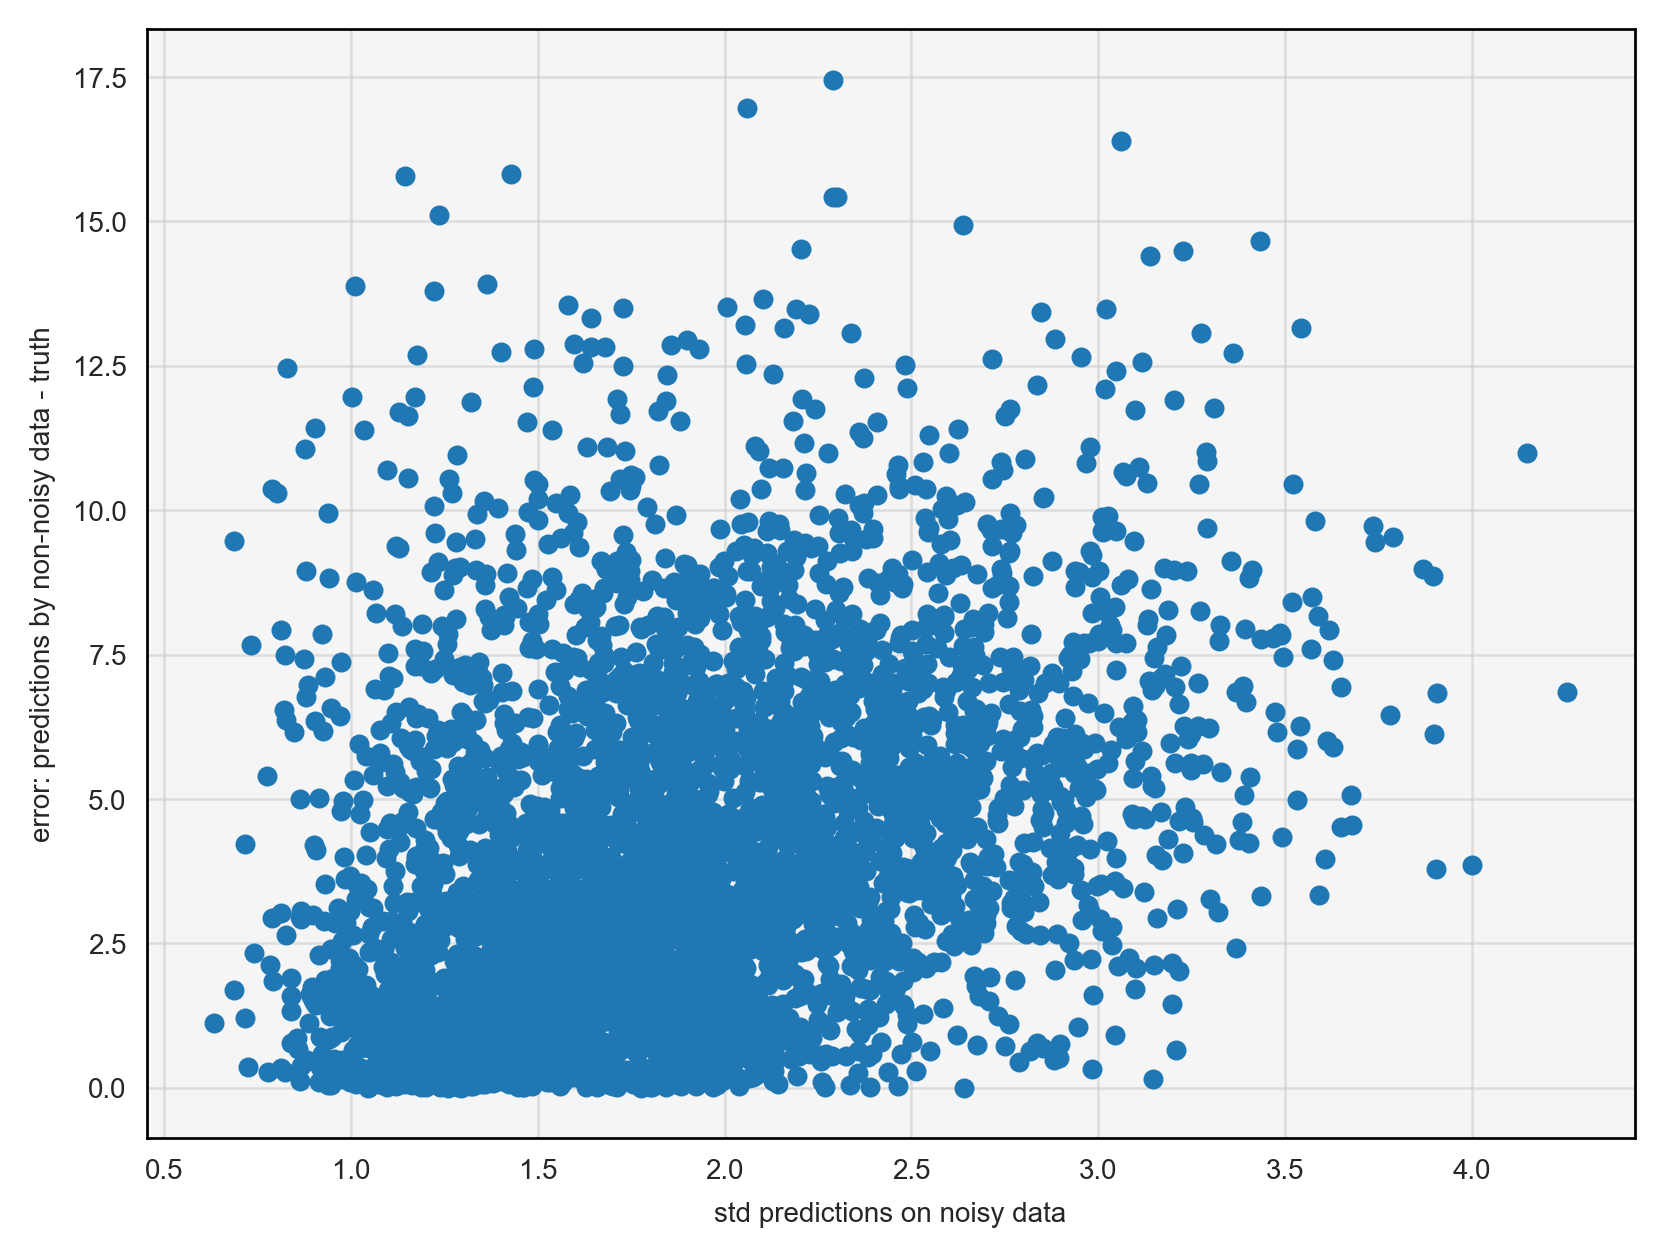

In [150]:
all_corrcoefs, all_stds = compute_corr_for_range_noises(
    model, data, 1000, noise_levels=[0.22]
)
ic(all_corrcoefs)

inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()

plt.scatter(np.squeeze(all_stds[0]), metrics["mae"].numpy())
plt.xlabel("std predictions on noisy data")
plt.ylabel("error: predictions by non-noisy data - truth")
plt.show()